In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# source files
import sys
sys.path.append('scripts/')
from scripts.calibrated_regression import CalibratedRegression
from scripts.data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

## Creating Data

(1250,) (250,) (1250,) (250,)


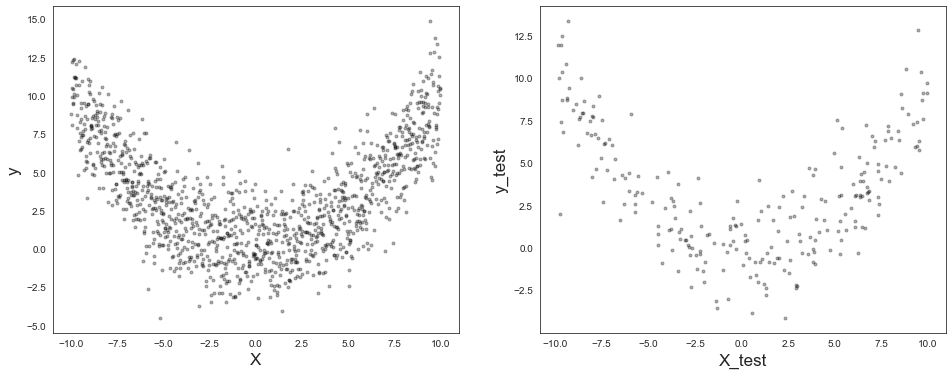

In [2]:
X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

## Polynomial Regression Model

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

In [3]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1201.26draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.097444,0.000982,0.000032,0.095599,0.099497,1007.899804,0.999563
b,0.006168,0.004995,0.000137,-0.003308,0.016051,1468.952453,1.000861
c,0.156195,0.042992,0.001334,0.068893,0.239672,1082.627468,0.999585


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [5]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,1.380921,3.769527,1.000,1.000
1,-1.541027,-2.110843,0.004,0.108
2,-0.140093,-0.487011,0.250,0.388
3,-5.116744,3.191662,0.698,0.640
4,5.116744,1.144413,0.051,0.204


[0.         0.452      0.99833333]


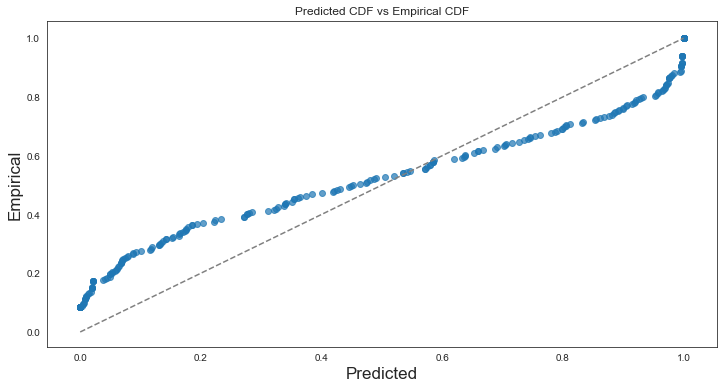

In [6]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

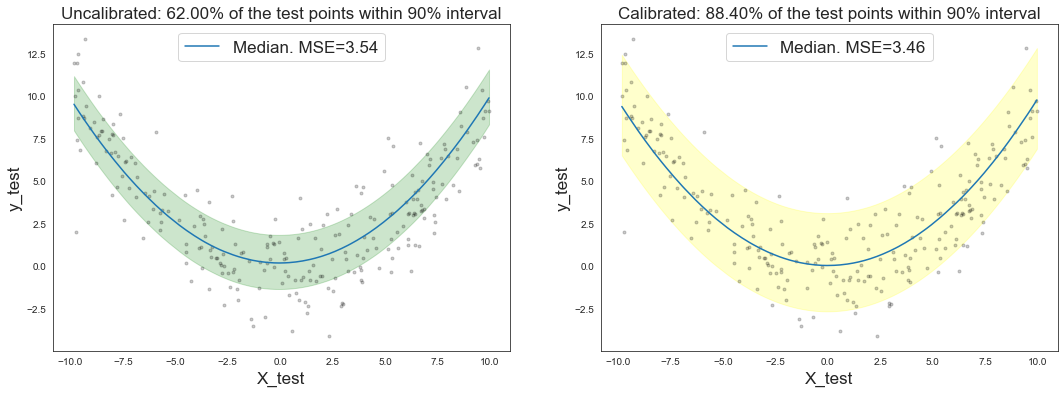

In [7]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

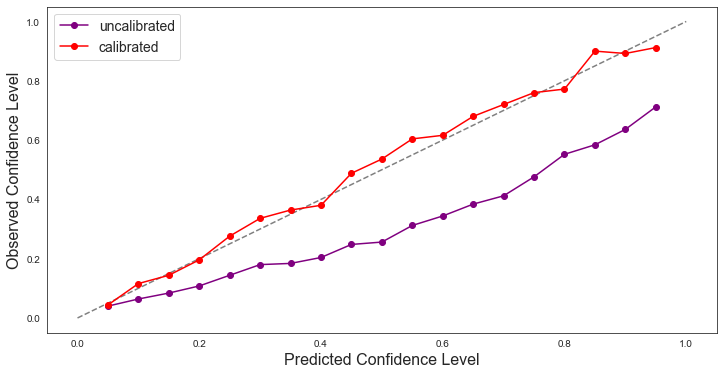

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

---